# Semantic Splitting

## 1. Imports

In [40]:
import textwrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wikipedia
from dotenv import load_dotenv
from litellm import embedding
from rich.align import Align
from rich.columns import Columns
from rich.console import Console
from rich.panel import Panel
from scipy.signal import find_peaks

load_dotenv()

True

## 2. Build The Example Document

<div><img src="../prep.gif" width="800px"/></div>


In [41]:
res = wikipedia.page("Linear Algebra", auto_suggest=False)
text_1 = res.content
section_1_1 = res.section(res.sections[3])
section_1_2 = res.section(res.sections[4])

res = wikipedia.page("Francis I of France", auto_suggest=False)
text_2 = res.content
section_2_1 = res.section(res.sections[5])
section_2_2 = res.section(res.sections[3])


sections = [section_1_1, section_2_1, section_1_2, section_2_2]

## 3. Define The Data Pipeline Steps

In [54]:
def sentence_splitter(df: pd.DataFrame) -> pd.DataFrame:
    """
    Splits the 'section' column of the input DataFrame into individual sentences.

    Args:
        df (pd.DataFrame): The input DataFrame containing a 'section_id' column and a 'section' column.

    Returns:
        pd.DataFrame: The modified DataFrame with the 'section' column split into individual sentences.

    """
    print("Before splitting in sentences")
    display(df.head(10))
    df = (
        df.set_index("section_id")
        .section.str.split("\. ", expand=True)
        .stack()
        .reset_index()
        .rename(columns={0: "sentence"})
        .drop(columns=["level_1"])
    )
    df["sentence"] = df["sentence"].str.strip()
    print("After splitting in sentences")
    display(df.head(10))
    print()
    return df


def sentence_grouper(df: pd.DataFrame, group_size: int) -> pd.DataFrame:
    """
    Groups sentences from a DataFrame into chunks of a specified size.

    Args:
        df (pd.DataFrame): The DataFrame containing the sentences to be grouped.
        group_size (int): The size of each group.

    Returns:
        pd.DataFrame: A DataFrame with the grouped sentences, section IDs, section split indicators,
                      and section split positions.

    """
    print("Before grouping in windows")
    display(df.iloc[5:15])
    groups = [df.iloc[i : i + group_size] for i in range(len(df) - group_size + 1)]
    df_grouped = pd.concat(
        [
            pd.DataFrame(
                {
                    "sentences": [group["sentence"].tolist()],
                    "section_ids": [group["section_id"].tolist()],
                    "section_split": [len(set(group["section_id"])) > 1],
                    "section_split_position": [
                        next(
                            (
                                i
                                for i in range(1, len(group))
                                if group["section_id"].iloc[i]
                                != group["section_id"].iloc[i - 1]
                            ),
                            -1,
                        )
                        if len(group) > 1
                        else -1
                    ],
                }
            )
            for group in groups
        ],
        ignore_index=True,
    )
    df_grouped.loc[~df_grouped["section_split"], "section_split_position"] = -1
    print("After grouping in windows")
    display(df_grouped.iloc[5:15])
    print()
    return df_grouped


def group_embedder(df: pd.DataFrame, batch_size: int) -> pd.DataFrame:
    """
    Embeds the sentences in the given DataFrame into two separate groups using a specified batch size.

    Args:
        df (pd.DataFrame): The DataFrame containing the sentences to be embedded.
        batch_size (int): The number of sentences to process in each batch.

    Returns:
        pd.DataFrame: The DataFrame with two additional columns, "embedding_1" and "embedding_2",
                      containing the embeddings of the sentences in the two groups.
    """
    print("Before computing embeddings")
    display(df.iloc[5:15])
    embeddings_1 = []
    embeddings_2 = []

    for i in range(0, len(df), batch_size):
        batch = df["sentences"].iloc[i : i + batch_size].tolist()
        batch_1 = [".".join(sentences[: len(sentences) // 2]) for sentences in batch]
        batch_2 = [".".join(sentences[len(sentences) // 2 :]) for sentences in batch]

        batch_embeddings_1 = [
            x["embedding"]
            for x in embedding(model="text-embedding-ada-002", input=batch_1).data
        ]
        batch_embeddings_2 = [
            x["embedding"]
            for x in embedding(model="text-embedding-ada-002", input=batch_2).data
        ]

        embeddings_1.extend(batch_embeddings_1)
        embeddings_2.extend(batch_embeddings_2)

    df["embedding_1"] = embeddings_1
    df["embedding_2"] = embeddings_2
    print("After computing embeddings")
    display(df.iloc[5:15])
    return df

<>:16: SyntaxWarning: invalid escape sequence '\.'
<>:16: SyntaxWarning: invalid escape sequence '\.'
/var/folders/3y/fmdcnnys28147_k97yh_db940000gn/T/ipykernel_63246/3022497766.py:16: SyntaxWarning: invalid escape sequence '\.'
  .section.str.split("\. ", expand=True)


## 4. Create The Dataframe

In [55]:
WINDOW_SIZE = 6
EMBEDDING_BATCH_SIZE = 200


df = pd.DataFrame({"section": sections, "section_id": range(len(sections))})

df = (
    df.pipe(sentence_splitter)
    .pipe(sentence_grouper, WINDOW_SIZE)
    .pipe(group_embedder, EMBEDDING_BATCH_SIZE)
)

Before splitting in sentences


,section,section_id
0,The study of those subsets of vector spaces th...,0
1,Although the Italian Wars (1494–1559) came to ...,1
2,Matrices allow explicit manipulation of finite...,2
3,Francis was also renowned as a man of letters....,3


After splitting in sentences


,section_id,sentence
0,0,The study of those subsets of vector spaces th...
1,0,These subsets are called linear subspaces
2,0,"More precisely, a linear subspace of a vector ..."
3,0,(These conditions suffice for implying that W ...
4,0,The span of S is also the intersection of all ...
5,0,"In other words, it is the smallest (for the in..."
6,0,"Equivalently, a set S of vectors is linearly i..."
7,0,If a spanning set S is linearly dependent (tha...
8,0,One may continue to remove elements of S until...
9,0,Such a linearly independent set that spans a v...



Before grouping in windows


,section_id,sentence
5,0,"In other words, it is the smallest (for the in..."
6,0,"Equivalently, a set S of vectors is linearly i..."
7,0,If a spanning set S is linearly dependent (tha...
8,0,One may continue to remove elements of S until...
9,0,Such a linearly independent set that spans a v...
10,0,The importance of bases lies in the fact that ...
11,0,"More precisely, if S is a linearly independent..."
12,0,"Moreover, two vector spaces over the same fiel..."
13,0,"If U is a subspace of V, then dim U ≤ dim V"
14,0,"In the case where V is finite-dimensional, the..."


After grouping in windows


,sentences,section_ids,section_split,section_split_position
5,"[In other words, it is the smallest (for the i...","[0, 0, 0, 0, 0, 0]",False,-1
6,"[Equivalently, a set S of vectors is linearly ...","[0, 0, 0, 0, 0, 0]",False,-1
7,[If a spanning set S is linearly dependent (th...,"[0, 0, 0, 0, 0, 0]",False,-1
8,[One may continue to remove elements of S unti...,"[0, 0, 0, 0, 0, 0]",False,-1
9,[Such a linearly independent set that spans a ...,"[0, 0, 0, 0, 0, 0]",False,-1
10,[The importance of bases lies in the fact that...,"[0, 0, 0, 0, 0, 1]",True,5
11,"[More precisely, if S is a linearly independen...","[0, 0, 0, 0, 1, 1]",True,4
12,"[Moreover, two vector spaces over the same fie...","[0, 0, 0, 1, 1, 1]",True,3
13,"[If U is a subspace of V, then dim U ≤ dim V, ...","[0, 0, 1, 1, 1, 1]",True,2
14,"[In the case where V is finite-dimensional, th...","[0, 1, 1, 1, 1, 1]",True,1



Before computing embeddings


,sentences,section_ids,section_split,section_split_position
5,"[In other words, it is the smallest (for the i...","[0, 0, 0, 0, 0, 0]",False,-1
6,"[Equivalently, a set S of vectors is linearly ...","[0, 0, 0, 0, 0, 0]",False,-1
7,[If a spanning set S is linearly dependent (th...,"[0, 0, 0, 0, 0, 0]",False,-1
8,[One may continue to remove elements of S unti...,"[0, 0, 0, 0, 0, 0]",False,-1
9,[Such a linearly independent set that spans a ...,"[0, 0, 0, 0, 0, 0]",False,-1
10,[The importance of bases lies in the fact that...,"[0, 0, 0, 0, 0, 1]",True,5
11,"[More precisely, if S is a linearly independen...","[0, 0, 0, 0, 1, 1]",True,4
12,"[Moreover, two vector spaces over the same fie...","[0, 0, 0, 1, 1, 1]",True,3
13,"[If U is a subspace of V, then dim U ≤ dim V, ...","[0, 0, 1, 1, 1, 1]",True,2
14,"[In the case where V is finite-dimensional, th...","[0, 1, 1, 1, 1, 1]",True,1


After computing embeddings


,sentences,section_ids,section_split,section_split_position,embedding_1,embedding_2
5,"[In other words, it is the smallest (for the i...","[0, 0, 0, 0, 0, 0]",False,-1,"[-0.0052983202040195465, 0.011773310601711273,...","[-0.0008539299014955759, -0.000832938530948013..."
6,"[Equivalently, a set S of vectors is linearly ...","[0, 0, 0, 0, 0, 0]",False,-1,"[-0.012355510145425797, 0.00022823186009190977...","[0.005658466834574938, -0.006928734946995974, ..."
7,[If a spanning set S is linearly dependent (th...,"[0, 0, 0, 0, 0, 0]",False,-1,"[0.008582459762692451, 0.0017416358459740877, ...","[0.002088377717882395, -0.01197647862136364, -..."
8,[One may continue to remove elements of S unti...,"[0, 0, 0, 0, 0, 0]",False,-1,"[-0.0008539299014955759, -0.000832938530948013...","[0.013889067806303501, -0.0067183710634708405,..."
9,[Such a linearly independent set that spans a ...,"[0, 0, 0, 0, 0, 0]",False,-1,"[0.005658466834574938, -0.006928734946995974, ...","[0.0021339920349419117, -0.0163432564586401, 0..."
10,[The importance of bases lies in the fact that...,"[0, 0, 0, 0, 0, 1]",True,5,"[0.002088377717882395, -0.01197647862136364, -...","[0.015284253284335136, -0.009481034241616726, ..."
11,"[More precisely, if S is a linearly independen...","[0, 0, 0, 0, 1, 1]",True,4,"[0.013857942074537277, -0.006762729026377201, ...","[0.01070993859320879, -0.00809495709836483, 0...."
12,"[Moreover, two vector spaces over the same fie...","[0, 0, 0, 1, 1, 1]",True,3,"[0.0021255421452224255, -0.016444899141788483,...","[0.010221374221146107, -0.008765798062086105, ..."
13,"[If U is a subspace of V, then dim U ≤ dim V, ...","[0, 0, 1, 1, 1, 1]",True,2,"[0.015312664210796356, -0.009342190809547901, ...","[0.0033914782106876373, -0.010626845993101597,..."
14,"[In the case where V is finite-dimensional, th...","[0, 1, 1, 1, 1, 1]",True,1,"[0.01070993859320879, -0.00809495709836483, 0....","[0.012353051453828812, -0.014167225919663906, ..."


## 5. Analysis

### 5.1. Create The Metrics Dataframe

In [44]:
df_metrics = df.copy()

df_metrics["similarity"] = df.apply(
    lambda x: np.dot(x["embedding_1"], x["embedding_2"]), axis=1
)
df_metrics["divergence"] = 1 - df_metrics["similarity"]

### 5.2. Can We See Something Interesting?

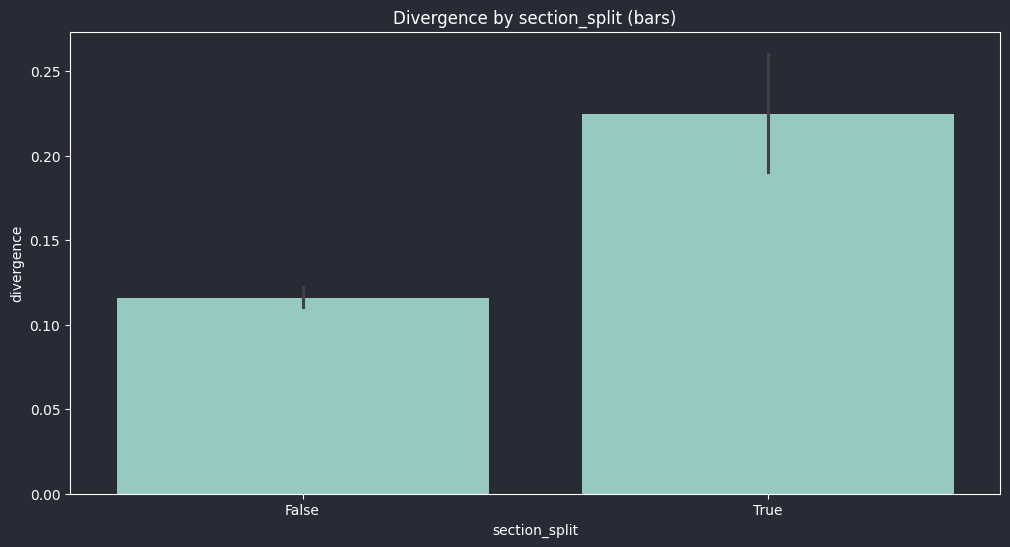

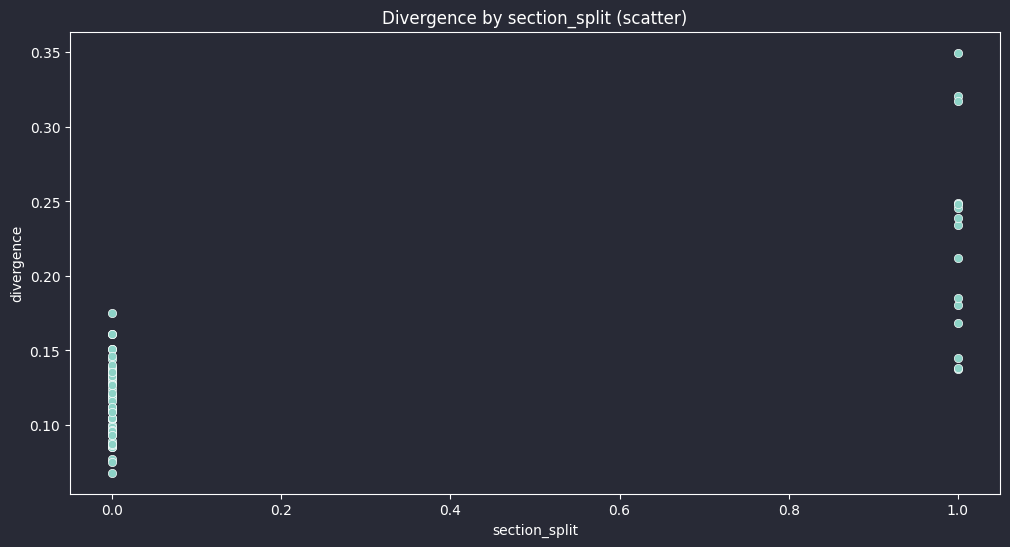

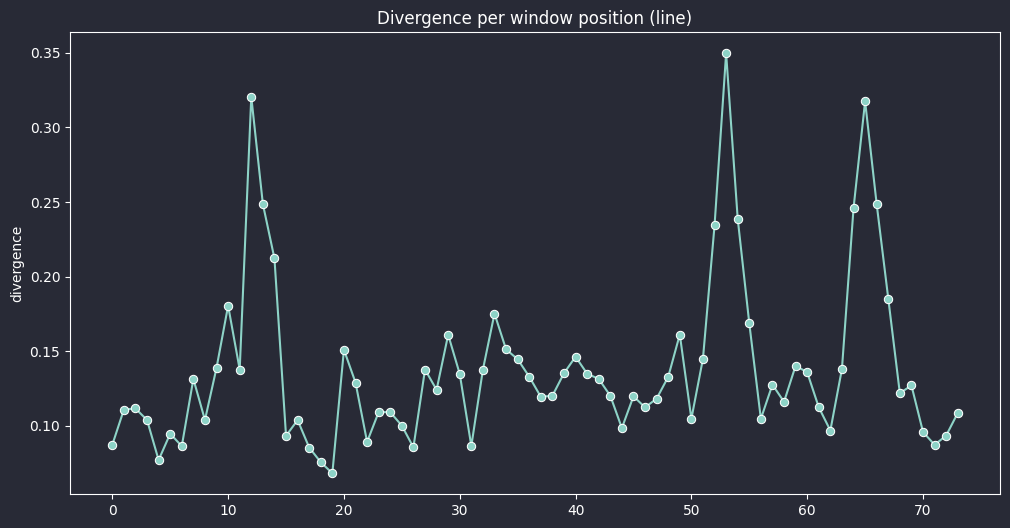

In [45]:
plt.style.use("dark_background")
plt.rcParams["figure.facecolor"] = "#282a36"
plt.rcParams["axes.facecolor"] = "#282a36"

plt.figure(figsize=(12, 6))
sns.barplot(x="section_split", y="divergence", data=df_metrics)
plt.title("Divergence by section_split (bars)")
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x="section_split", y="divergence", data=df_metrics)
plt.title("Divergence by section_split (scatter)")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=np.arange(df_metrics["divergence"].size),
    y=df_metrics["divergence"],
    data=df_metrics,
    marker="o",
)
plt.title("Divergence per window position (line)")
plt.show()

### 5.3. Automatic Semantic Split

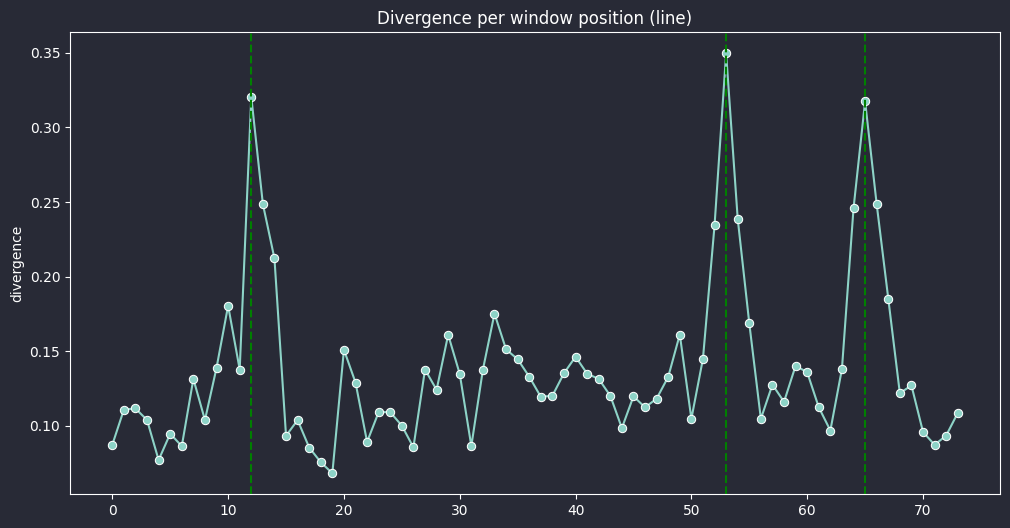

In [48]:

peaks = find_peaks(
    df_metrics["divergence"], height=df_metrics["divergence"].max() * 0.8
)


plt.figure(figsize=(12, 6))
sns.lineplot(
    x=np.arange(df_metrics["divergence"].size),
    y=df_metrics["divergence"],
    data=df_metrics,
    marker="o",
)
for peak in peaks[0]:
    plt.axvline(x=peak, color="g", linestyle="--")

plt.title("Divergence per window position (line)")
plt.show()

### 5.4. Comparing Before/After Breakpoints

In [ ]:
console = Console(width=100)

for peak in peaks[0]:
    x = df_metrics.iloc[peak]

    mid = len(x["sentences"]) // 2
    before_peak = x["sentences"][0:mid]
    after_peak = x["sentences"][mid:]

    before_peak_text = textwrap.fill(". ".join(before_peak), 80)
    after_peak_text = textwrap.fill(". ".join(after_peak), 80)

    columns = Columns(
        [
            Panel(
                before_peak_text, title="Before Peak", width=80, border_style="#1ddd78"
            ),
            Panel(
                after_peak_text, title="After peak", width=80, border_style="#0086ff"
            ),
        ]
    )
    console.print(
        Panel(Align.center(columns, vertical="middle"), title=f"Peak at index {peak}")
    )

╭──────────────────────────────────────── Peak at index 12 ────────────────────────────────────────╮
│         ╭──────────────────────────────── Before Peak ─────────────────────────────────╮         │
│         │ Moreover, two vector spaces over the same field F are isomorphic if and only │         │
│         │ if                                                                           │         │
│         │ they have the same dimension. If any basis of V (and therefore every basis)  │         │
│         │ has                                                                          │         │
│         │ a finite number of elements, V is a finite-dimensional vector space. If U is │         │
│         │ a                                                                            │         │
│         │ subspace of V, then dim U ≤ dim V. In the case where V is                    │         │
│         │ finite-dimensional,                                                          │         │
│         │ the equality of the dimensions implies U = V. If U1 and U2 are subspaces of  │         │
│         │ V,                                                                           │         │
│         │ then                         dim         ⁡         (                    U     │         │
│         │ 1                             +                    U                         │         │
│         │ 2                                                                            │         │
│         │ )         =         dim         ⁡                    U                        │         │
│         │ 1                                                                            │         │
│         │ +         dim         ⁡                    U                        2         │         │
│         │ −         dim         ⁡         (                    U                        │         │
│         │ 1                                                                            │         │
│         │ ∩                    U                        2                              │         │
│         │ )                                                                            │         │
│         │ ,                 {\displaystyle \dim(U_{1}+U_{2})=\dim U_{1}+\dim           │         │
│         │ U_{2}-\dim(U_{1}\cap U_{2}),}     where U1 + U2 denotes the span of U1 ∪ U2. │         │
│         ╰──────────────────────────────────────────────────────────────────────────────╯         │
│         ╭───────────────────────────────── After peak ─────────────────────────────────╮         │
│         │ Although the Italian Wars (1494–1559) came to dominate the reign of Francis  │         │
│         │ I,                                                                           │         │
│         │ which he constantly participated in at the forefront as le Roi-Chevalier,    │         │
│         │ the                                                                          │         │
│         │ wars were not the sole focus of his policies. He merely continued the wars   │         │
│         │ that                                                                         │         │
│         │ he succeeded from his predecessors and that his heir and successor on the    │         │
│         │ throne, Henry II of France, would inherit after Francis' death. Indeed, the  │         │
│         │ Italian Wars had begun when Milan sent a plea to King Charles VIII of France │         │
│         │ for                                                                          │         │
│         │ protection against the aggressive actions of the King of Naples              │         │
│         ╰──────────────────────────────────────────────────────────────────────────────╯         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────── Peak at index 53 ────────────────────────────────────────╮
│         ╭──────────────────────────────── Before Peak ─────────────────────────────────╮         │
│         │ The agreement collapsed, however, which led to Francis' final attempt on     │         │
│         │ Italy                                                                        │         │
│         │ in the Italian War of 1542–1546. Francis I managed to hold off the forces of │         │
│         │ Charles and Henry VIII. Charles was forced to sign the Treaty of Crépy       │         │
│         │ because                                                                      │         │
│         │ of his financial difficulties and conflicts with the Schmalkaldic League.    │         │
│         ╰──────────────────────────────────────────────────────────────────────────────╯         │
│         ╭───────────────────────────────── After peak ─────────────────────────────────╮         │
│         │ Matrices allow explicit manipulation of finite-dimensional vector spaces and │         │
│         │ linear maps. Their theory is thus an essential part of linear algebra. Let V │         │
│         │ be                                                                           │         │
│         │ a finite-dimensional vector space over a field F, and (v1, v2, ..., vm) be a │         │
│         │ basis of V (thus m is the dimension of V). By definition of a basis, the map │         │
│         │ (                                    a                                       │         │
│         │ 1                                                                            │         │
│         │ ,                 …                 ,                                    a   │         │
│         │ m                                                     )                      │         │
│         │ ↦                                    a                                       │         │
│         │ 1                                                                            │         │
│         │ v                                                           1                │         │
│         │ +                 ⋯                                    a                     │         │
│         │ m                                                                            │         │
│         │ v                                                           m                │         │
│         │ F                                        m                                   │         │
│         │ →                 V                                                          │         │
│         │ {\displaystyle {\begin{aligned}(a_{1},\ldots ,a_{m})&\mapsto a_{1}\mathbf    │         │
│         │ {v}                                                                          │         │
│         │ _{1}+\cdots a_{m}\mathbf {v} _{m}\\F^{m}&\to V\end{aligned}}}     is a       │         │
│         │ bijection                                                                    │         │
│         │ from Fm, the set of the sequences of m elements of F, onto V                 │         │
│         ╰──────────────────────────────────────────────────────────────────────────────╯         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────── Peak at index 65 ────────────────────────────────────────╮
│         ╭──────────────────────────────── Before Peak ─────────────────────────────────╮         │
│         │ Every matrix is similar to an identity matrix possibly bordered by zero rows │         │
│         │ and                                                                          │         │
│         │ zero columns. In terms of vector spaces, this means that, for any linear map │         │
│         │ from W to V, there are bases such that a part of the basis of W is mapped    │         │
│         │ bijectively on a part of the basis of V, and that the remaining basis        │         │
│         │ elements                                                                     │         │
│         │ of W, if any, are mapped to zero. Gaussian elimination is the basic          │         │
│         │ algorithm                                                                    │         │
│         │ for finding these elementary operations, and proving these results.          │         │
│         ╰──────────────────────────────────────────────────────────────────────────────╯         │
│         ╭───────────────────────────────── After peak ─────────────────────────────────╮         │
│         │ Francis was also renowned as a man of letters. When he comes up in a         │         │
│         │ conversation among characters in Baldassare Castiglione's Book of the        │         │
│         │ Courtier,                                                                    │         │
│         │ it is as the great hope to bring culture to the war-obsessed French nation.  │         │
│         │ Not                                                                          │         │
│         │ only did Francis support a number of major writers of the period, but he was │         │
│         │ also a poet himself, if not one of particular ability                        │         │
│         ╰──────────────────────────────────────────────────────────────────────────────╯         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯